## Clustering - Preparation for later similarity scoring

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

from matplotlib import pyplot as plt

# Add project root to path - notebook version
notebook_dir = Path.cwd()
project_root = notebook_dir.parent  # Goes up from notebooks/ to project root
src = project_root / "src"

sys.path.insert(0, str(project_root))
sys.path.insert(1, str(src))

# Now you can import from config (at root level)
from config.config import settings


# Load the data
data_path = project_root / "data" / "raw" / "cs-test.csv"
df = pd.read_csv(data_path)

# Display basic info
display(df.head())

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


## 1. Preprocessing the data

In [2]:
from xai_pkg.model_explainer.predictor import CreditPredictor
from config.config import settings


from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load model config to ensure consistency
import json
with open(settings["METADATA_PATH"], 'r') as f:
    config = json.load(f)

print("Using model preprocessing configuration:")
print(f"- Log transform features: {config.get('log_scale_features', [])}")
print(f"- Trimmed values: {config['trimmed_values']}")
print(f"- Used features: {config['used_features']}")

# Load the model
model = CreditPredictor.load_model()

# Apply manual preprocessing
df = model._preprocess_input(df)

# Use model pipelines preprocessor to preprocess the data
df_scaled = model.model_preprocessor.transform(df)

# Ensure we have a DataFrame with proper column names
if not isinstance(df_scaled, pd.DataFrame):
    feature_names = model.model_preprocessor.get_feature_names_out()
    df_scaled = pd.DataFrame(df_scaled, columns=feature_names)
else:
    # If it's already a DataFrame but column names might be wrong, fix them
    df_scaled.columns = model.model_preprocessor.get_feature_names_out()

# Summary statistics
print("\nPreprocessed data summary:")
print(f"  Final shape: {df_scaled.shape}")
print(f"  Features used: {list(df_scaled.columns)}")
print(f"  Any nulls remaining: {df_scaled.isnull().sum().sum()}")

INFO:xai_pkg.model_explainer.predictor:CreditPredictor initialized with XGBoost model
INFO:xai_pkg.model_explainer.predictor:Model loaded from ../output/models/best_model.pkl


Using model preprocessing configuration:
- Log transform features: []
- Trimmed values: {'RevolvingUtilizationOfUnsecuredLines': [0, 1.0929557681400022], 'DebtRatio': [0, 2.4702802109800093], 'MonthlyIncome': [0, 23000.0]}
- Used features: ['age', 'NumberOfDependents', 'MonthlyIncome', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'imputed_income']

Preprocessed data summary:
  Final shape: (101503, 11)
  Features used: ['age', 'NumberOfDependents', 'MonthlyIncome', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'imputed_income']
  Any nulls remaining: 0


## 2. Determining the optimal number of clusters

k=2: Inertia=539111, Silhouette=0.242
k=3: Inertia=471566, Silhouette=0.244
k=4: Inertia=411081, Silhouette=0.237
k=5: Inertia=376101, Silhouette=0.179
k=6: Inertia=349730, Silhouette=0.181


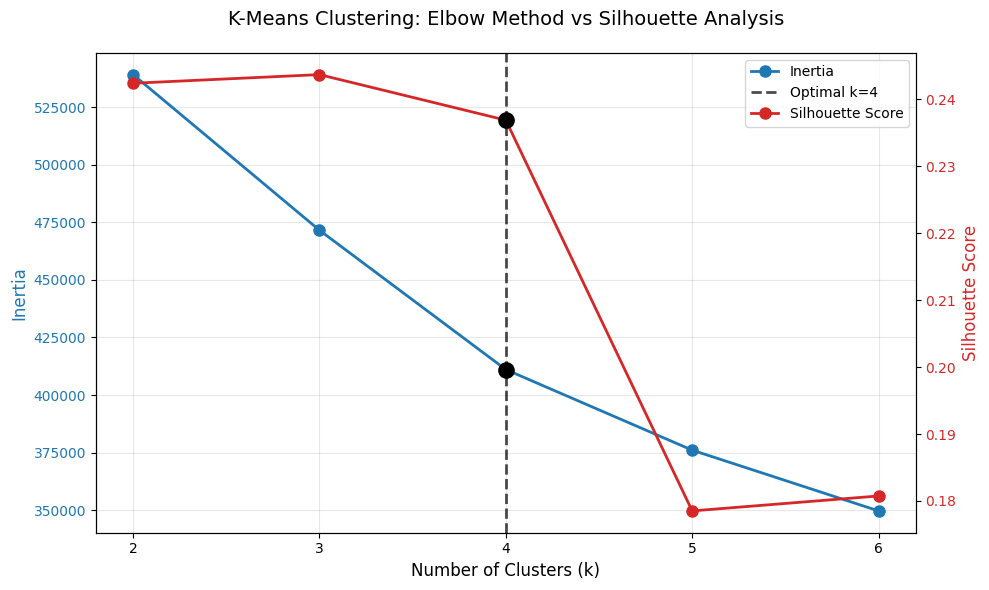


Optimal k set to: 4
  - Inertia at k=4: 411081
  - Silhouette score at k=4: 0.237


In [3]:
# Use MiniBatchKMeans which is more stable for large datasets with outliers
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_k = 6

# Test different k values
inertias = []
silhouette_scores_list = []
K_range = range(2, max_k + 1)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    for k in K_range:
        kmeans = KMeans(
            n_clusters=k,
            random_state=settings["RANDOM_SEED"],
            n_init=2,
            max_iter=300
        )
        
        labels = kmeans.fit_predict(df_scaled)
        inertias.append(kmeans.inertia_)
        
        # Calculate silhouette on a sample for speed
        sample_size = min(10000, len(df_scaled))
        sample_indices = np.random.RandomState(settings["RANDOM_SEED"]).choice(len(df_scaled), sample_size, replace=False)
        sil_score = silhouette_score(df_scaled.iloc[sample_indices], labels[sample_indices])
        silhouette_scores_list.append(sil_score)
        
        print(f"k={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={sil_score:.3f}")

# Plot results - Combined plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia (elbow method) on primary y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', color=color1, fontsize=12)
line1 = ax1.plot(K_range, inertias, 'o-', linewidth=2, markersize=8, color=color1, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary y-axis for silhouette scores
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2, fontsize=12)
line2 = ax2.plot(K_range, silhouette_scores_list, 'o-', linewidth=2, markersize=8, color=color2, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)


optimal_k = 4

# Highlight the optimal k point
optimal_idx = K_range.index(optimal_k)
ax1.axvline(x=optimal_k, color='black', linestyle='--', alpha=0.7, linewidth=2, label=f'Optimal k={optimal_k}')
ax1.scatter(optimal_k, inertias[optimal_idx], color='black', s=100, zorder=5, linewidth=2)
ax2.scatter(optimal_k, silhouette_scores_list[optimal_idx], color='black', s=100, zorder=5, linewidth=2)

# Add grid and title
ax1.grid(True, alpha=0.3)
ax1.set_xticks(K_range)
ax1.set_xticklabels(K_range)

plt.title('K-Means Clustering: Elbow Method vs Silhouette Analysis', fontsize=14, pad=20)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Print optimal k
print(f"\nOptimal k set to: {optimal_k}")
print(f"  - Inertia at k={optimal_k}: {inertias[optimal_idx]:.0f}")
print(f"  - Silhouette score at k={optimal_k}: {silhouette_scores_list[optimal_idx]:.3f}")

## 3. Fitting and assigning the clusters

In [4]:
# Fit KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=settings["RANDOM_SEED"], n_init=10)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    cluster_labels = kmeans.fit_predict(df_scaled)

# Assign cluster labels to the original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

## 4. Cluster analysis

,Cluster,Count,Percentage
0,Cluster 0,55112,54.3%
1,Cluster 1,12869,12.7%
2,Cluster 2,18159,17.9%
3,Cluster 3,15363,15.1%


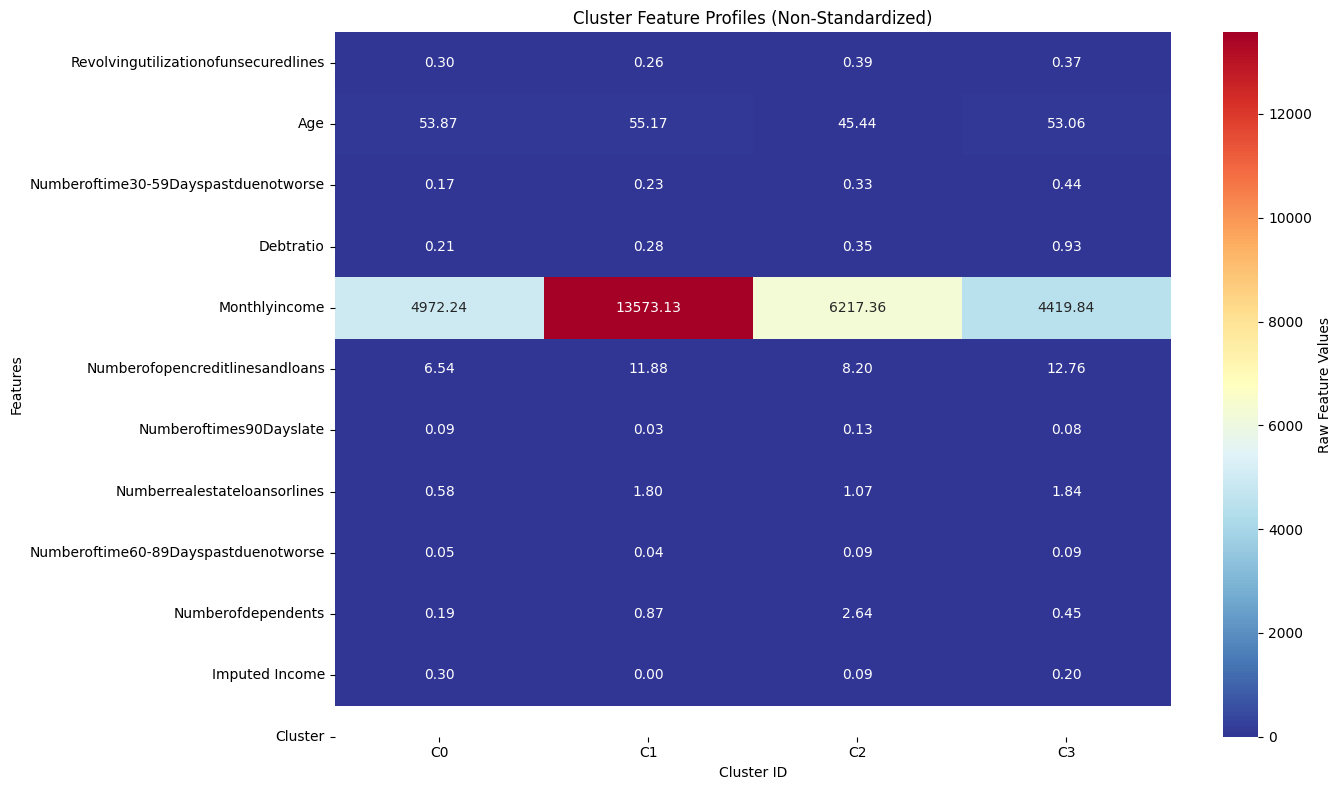

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,imputed_income
cluster,,,,,,,,,,,
0,0.299,53.870,0.171,0.210,4972.241,6.538,0.093,0.583,0.054,0.191,0.297
1,0.257,55.169,0.233,0.276,13573.129,11.883,0.035,1.797,0.042,0.868,0.000
2,0.392,45.445,0.330,0.347,6217.360,8.196,0.131,1.065,0.087,2.645,0.094
3,0.371,53.063,0.435,0.935,4419.838,12.756,0.078,1.839,0.088,0.448,0.199


In [5]:
import seaborn as sns

# Create cluster summary dataframe
cluster_summary_data = []
n_clusters = optimal_k
feature_cols = df_clustered.columns

for cluster_id in range(n_clusters):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    # Calculate key statistics for each cluster
    cluster_stats = {
        'Cluster': f'Cluster {cluster_id}',
        'Count': len(cluster_data),
        'Percentage': f"{len(cluster_data)/len(df)*100:.1f}%"
    }
    
    # Add feature means for all features (non-standardized)
    for feat in feature_cols:
        if feat in cluster_data.columns:
            cluster_mean = cluster_data[feat].mean()
    
    cluster_summary_data.append(cluster_stats)

# Create summary dataframe
cluster_summary_df = pd.DataFrame(cluster_summary_data)
display(cluster_summary_df)

# Create detailed comparison heatmap (non-standardized)
plt.figure(figsize=(14, 8))

# Calculate cluster means
cluster_means = df_clustered.groupby('cluster')[feature_cols].mean()
cluster_means = cluster_means.drop(columns=['cluster'])

# Create non-standardized heatmap (raw values)
sns.heatmap(cluster_means.T,
            annot=True,
            fmt='.2f',
            cmap='RdYlBu_r',
            xticklabels=[f'C{i}' for i in range(n_clusters)],
            yticklabels=[f.replace('_', ' ').title() for f in feature_cols],
            cbar_kws={'label': 'Raw Feature Values'})
plt.title('Cluster Feature Profiles (Non-Standardized)')
plt.xlabel('Cluster ID')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

display(cluster_means.round(3))

## 5. Assign labels to all test cases for prediction sampling

In [6]:
# Save indexes and assigned clusters to a json for later mapping 

import json

# Create a dictionary mapping index to cluster
index_to_cluster = {str(idx): int(cluster_id) for idx, cluster_id in enumerate(df_clustered['cluster'])}

# Calculate cluster distribution
from collections import Counter
cluster_distribution = dict(Counter(df_clustered['cluster']))

# Create cluster metadata
cluster_metadata = {
    'generation_timestamp': pd.Timestamp.now().isoformat(),
    'n_clusters': optimal_k,
    'total_instances': len(index_to_cluster),
    'clustering_algorithm': 'KMeans',
    'cluster_distribution': {int(k): int(v) for k, v in cluster_distribution.items()},
    'features_used': list(feature_cols)
}

# Save lightweight cluster assignments
cluster_output = {
    'metadata': cluster_metadata,
    'index_to_cluster': index_to_cluster
}

# Ensure output directory exists
output_dir = project_root / "output" / "clustering"
output_dir.mkdir(parents=True, exist_ok=True)
cluster_file_path = output_dir / "cluster_assignments.json"

# Save to file
with open(cluster_file_path, 'w') as f:
    json.dump(cluster_output, f, indent=2)

print(f"✅ Cluster assignments saved to: {cluster_file_path}")
print(f"📊 Total instances: {len(index_to_cluster)}")
print(f"🎯 Clusters: {optimal_k}")

# Display cluster distribution
print("\n🎯 Cluster Distribution:")
for cluster_id in sorted(cluster_distribution.keys()):
    count = cluster_distribution[cluster_id]
    percentage = (count / len(index_to_cluster)) * 100
    print(f"  Cluster {cluster_id}: {count:,} instances ({percentage:.1f}%)")

print(f"\n💾 Saved cluster assignments for prediction sampling!")

✅ Cluster assignments saved to: /Users/timo/Documents/Thesis/xai-credit-decisions/output/clustering/cluster_assignments.json
📊 Total instances: 101503
🎯 Clusters: 4

🎯 Cluster Distribution:
  Cluster 0: 55,112 instances (54.3%)
  Cluster 1: 12,869 instances (12.7%)
  Cluster 2: 18,159 instances (17.9%)
  Cluster 3: 15,363 instances (15.1%)

💾 Saved cluster assignments for prediction sampling!
